In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


import os, math
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
class ResNet18Regressor(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Regressor, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.resnet(x)
        return out

In [3]:


class CircleRadiusDataset(Dataset):
    def __init__(self, image_dir, csv_file,  means = [0], stds = [1], test=False):
        # In test mode, we need to use the mean and standard deviation computed from the training set
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.means = []
        self.stds = []
        if not test:
            for col in self.df.columns[1:]:
                self.means.append(self.df[col].mean())
                self.stds.append(self.df[col].std())
                self.df[col] = (self.df[col] - self.means[-1]) / self.stds[-1]
                self.df[col] = self.df[col].astype('float32')
            print (self.means)
            print (self.stds)
        else:
            for i, col in enumerate(self.df.columns[1:]):
                self.df[col] = (self.df[col] - means[i]) / stds[i]
                self.df[col] = self.df[col].astype('float32')            
            
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        xs = self.df.iloc[idx, 1:len(self.df.columns)].values
        
        # The transform below is required by Resnet 18
        preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
        input_tensor = preprocess(image)
        #input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

        return input_tensor, torch.from_numpy(np.array(xs, dtype=np.float32))


In [7]:
import pickle
with open('resnet_arrow.pickle', 'rb') as picklefile:
    model = pickle.load(picklefile)
    
train_mean = np.array([14.998477309521844, 111.02903208428097, 111.92615894788703, 0.004743178609792218, 0.0051306632839993585])
train_std = np.array([2.395358926446069, 52.54662315834066, 52.60121424409957, 0.7050827517511564, 0.7091611219266939])
    
test_dataset = CircleRadiusDataset(image_dir="./arrowed_test", csv_file="./ArrowInfo_test.csv",
                                   means = train_mean, 
                                   stds = train_std,
                                   test=True)    

In [ ]:
device = torch.device("cpu")
print ('Device:', device)
model.to(device)

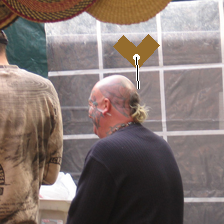

In [9]:
# Single image validation
import random
i = random.randint(0, 1000)

img_tensor, x = test_dataset.__getitem__(i)
input_tensor = img_tensor.to(device)
outputs = model(input_tensor.unsqueeze(0))

image = Image.open('arrowed_test/arrowed_' + str(i).zfill(4) + '.png').convert("RGB")
s, cx, cy, cos, sin = (outputs.cpu().detach().numpy() * train_std + train_mean)[0]


draw = ImageDraw.Draw(image)
draw.ellipse((cx-3,cy-3,cx+3,cy+3),  'white')
draw.line((cx,cy,cx+cos*s*2,cy+sin*s*2),  width = 3, fill='white')
draw.line((cx,cy,cx+cos*s*2,cy+sin*s*2),  width = 1, fill='black')
display(image)